# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [5]:
%matplotlib inline

import os
import sys 
import json
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from datetime import date
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.results import Results
from cloudscope.viz import draw_topology
from cloudscope.viz import plot_workload
from cloudscope.viz import plot_message_traffic
from cloudscope.utils.timez import epochptime

matplotlib.style.use('ggplot')

In [6]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures", "results")
# RESULTS  = os.path.join(FIXTURES, 'test-raft-single.json')
RESULTS  = os.path.join(FIXTURES, 'test-eventual-single.json')
# RESULTS  = os.path.join(FIXTURES, 'test-tags-single.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return Results.load(f)

# Load the data
results = get_results_data()

In [7]:
def title(text):
    return " ".join([t.capitalize() for t in text.split("_")])

def report_details():
    banner = (
        "Simulation: {} (Cloudscope v{})\n"
        "{}\n\n"
        "Ran on: {} ({})\n\n"
        "Settings\n"
        "========\n"
    ).format(
        results.simulation, results.version, results.topology['meta']['description'],
        epochptime(results.timer['started']).strftime('%b %d, %Y at %H:%M %Z'), 
        results.timer['elapsed'],
        results.randseed,
    )
    
    longest = max(len(key) for key in results.settings)
    frmt = "{{: <{0}}} {{: >12}}".format(longest)
    
    
    return banner + "\n".join([
        frmt.format(title(key), value)
        for key, value in results.settings.items()
    ])
    

def report_topology():
    topology = deepcopy(results.topology)
    nodes = topology['nodes']
    links = topology['links']
    
    for link in links:
        latency = [link['latency']] if link['connection'] == 'constant' else link['latency']
        
        for rid in ('source', 'target'):
            node = nodes[link[rid]]
            
            if 'minlat' not in node:
                node['minlat'] = latency[0]
            else:
                
                node['minlat'] = min(node['minlat'], latency[0])

            if 'maxlat' not in node:
                node['maxlat'] = latency[-1]
            else:
                node['maxlat'] = max(node['maxlat'], latency[-1])
         
    output = []
    for node in sorted(nodes, key=itemgetter('id')):
        output.append(
            "{}: {} ({}, {}) {}-{}ms connection".format(
                node['id'], node['label'], node['location'], node['consistency'], node['minlat'], node['maxlat']
            )
        )
    return "\n".join(output)

In [8]:
def create_dataframe():
    
    # Handlers for various rows: return a dictionary to add to data frame. 
    def default_handler(key, values):
        return {
            key: len(values) 
        }
    
    def handle_visibility_latency(key, values):
        return {
            "visibility latency (ms)": sum(v[2] - v[1] for v in values) / len(values), 
            "visible writes": len(set([v[1] for v in values]))
        }
    
    def handle_commit_latency(key, values):
        return {
            "commit latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
            "committed writes": len(set([v[1] for v in values]))
        }

    def handle_session_length(key, values):
        return {
            "sessions": len(values), 
            "mean session duration (ms)": sum(v[0] for v in values) / len(values),
        }

    def handle_read_latency(key, values):
        return {
            "completed reads": len(values), 
            "mean read latency (ms)": sum(v[0] for v in values) / len(values),
        }
    
    def handle_tag_size(key, values):
        return {
            "average tag size": sum(v[1] for v in values) / len(values)
        }
    
    def rename_key(name, func=default_handler):
        def handle_rename(key, values):
            item = func(key, values)
            return {
                name: item[key]
            }
        return handle_rename
        

    # Handler map 
    handlers = {
        'visibility latency': handle_visibility_latency, 
        'commit latency': handle_commit_latency, 
        'session length': handle_session_length,
        'read latency': handle_read_latency,
        'tag size': handle_tag_size,
        'read': rename_key('reads'),
        'write': rename_key('writes'),
    }
    
    replicas = defaultdict(lambda: defaultdict(list)) 
    topology = results.topology
    config   = results.settings
    series   = results.results
    
    # Extract per-replica ID values from all results series 
    for key, values in series.iteritems():
        for value in values:
            # Some quick checks 
            assert len(value) > 1 
            assert value[0].startswith('r')
            
            # Append the series to the specific replica 
            replicas[value[0]][key].append(value[1:])
    
    # Create a table with each replica id
    table = []
    for replica, series in replicas.iteritems():
        row = {'replica': replica} 
        
        # Perform per-replica aggreations for each result set 
        for serie, values in series.iteritems():
            handler = handlers.get(serie, default_handler)
            row.update(handler(serie, values))
        
        # Add in topology information 
        
        
        table.append(row)
    
    # Create the data frame and compute aggregate dependency items 
    df = pd.DataFrame(sorted(table, key=itemgetter('replica')))
    df['missed reads'] = df['reads'] - df['completed reads']
    df['dropped writes'] = df['writes'] - df ['visible writes']
    df['visibility ratio'] = df['visible writes'] / df['writes']
    
    return df

df = create_dataframe()
df 

,completed reads,mean read latency (ms),reads,recv,replica,sent,visibility latency (ms),visible writes,writes,missed reads,dropped writes,visibility ratio
0,2,0,2,73,r0,75,NaN,NaN,5,0,NaN,NaN
1,1,0,1,83,r1,86,2594,1,7,0,6,0.142857
2,NaN,NaN,NaN,71,r2,74,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,75,r3,76,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,68,r4,72,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,66,r5,70,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,68,r6,72,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,71,r7,75,NaN,NaN,NaN,NaN,NaN,NaN


# Results 

In [9]:
print report_details()

Simulation: Eventually There (Cloudscope v0.3)
Single Consistency Type: An Eventually Consistent Data Center.

Ran on: Mar 15, 2016 at 20:14 UTC (0 second)

Settings
Access Stddev                 512
Do Rumoring                     1
Switch Prob                   0.3
Move Prob                     0.2
Default Latency               800
Do Gossip                       1
Max Sim Time                25000
Random Seed                    42
Access Mean                  1800
Election Timeout       [150, 300]
Heartbeat Interval             75
Default Consistency        strong
Invalid Types         [u'backup']
Read Prob                    0.68
Users                           1
Max Objects Accessed           10
Anti Entropy Delay            600
Object Prob                   0.3
Valid Locations      [u'home', u'work', u'mobile', u'cloud']
Session Timeout               300
Default Replica           storage
Count Messages                  1


## Topology

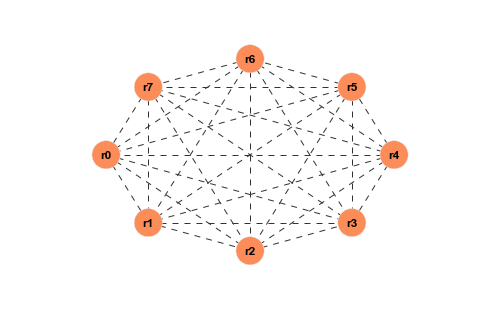

In [10]:
draw_topology(json_graph.node_link_graph(results.topology))

In [11]:
print report_topology()

r0: Eventual 1 (cloud, low) 300-1500ms connection
r1: Eventual 2 (cloud, low) 300-1500ms connection
r2: Eventual 3 (cloud, low) 300-1500ms connection
r3: Eventual 4 (cloud, low) 300-1500ms connection
r4: Eventual 5 (cloud, low) 300-1500ms connection
r5: Eventual 6 (cloud, low) 300-1500ms connection
r6: Eventual 7 (cloud, low) 300-1500ms connection
r7: Eventual 8 (cloud, low) 300-1500ms connection


## Workload

<module 'matplotlib.pyplot' from '/Users/benjamin/.virtualenvs/cloudscope/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

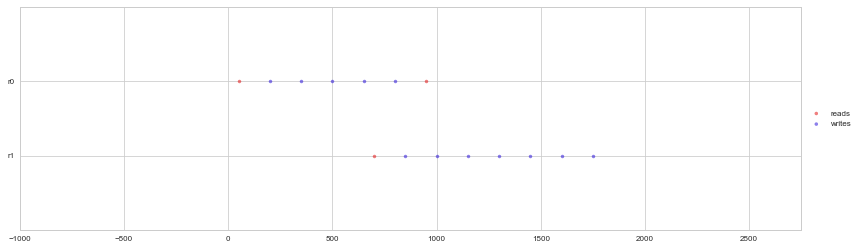

In [12]:
# Create the workload timeline plot 
plot_workload(results, devices=True)

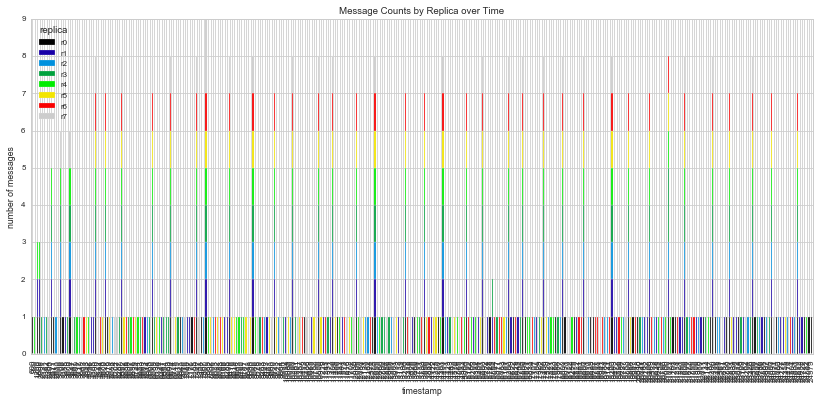

In [13]:
# Create the sent messages timeline
plot_message_traffic(results.results['sent'])

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

Accesses
3.0 Total Reads, 12.0 Total Writes 
1.5 average reads per replica
6.0 average writes per replica



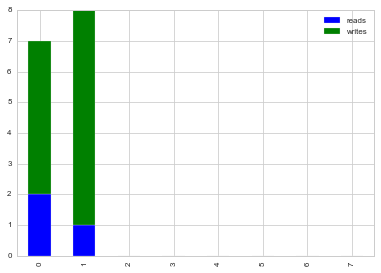

In [14]:
# Extract accesses 
accesses = pd.DataFrame(df, columns=['reads', 'writes'])

print (
    "Accesses\n"
    "========\n"
    "{} Total Reads, {} Total Writes \n"
    "{:0.1f} average reads per replica\n"
    "{:0.1f} average writes per replica\n"
).format(
    df.reads.sum(), df.writes.sum(), df.reads.mean(), df.writes.mean()
)

accesses.plot(kind='bar', stacked=True)

### Stale Reads

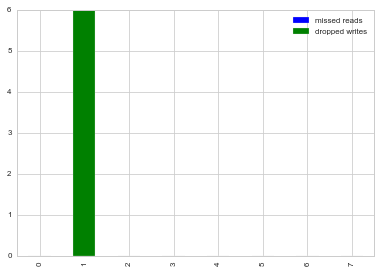

In [15]:
errors = pd.DataFrame(df, columns=['missed reads', 'dropped writes'])
errors.plot(kind='bar', stacked=True)

### Visibility Latency 

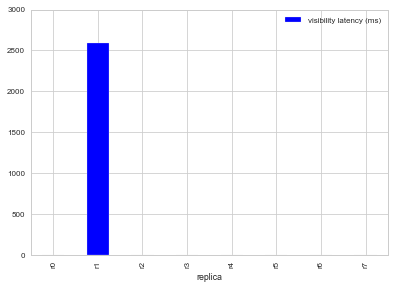

In [16]:
df.plot(kind='bar', x='replica', y='visibility latency (ms)')